In [1]:
# !pip install --upgrade keras==3.0.0
# !pip install --upgrade tensorflow
# !pip install --upgrade scikit-learn
# !pip install keras_nlp
# !pip install opendatasets

In [2]:
# Thư viện
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
# %matplotlib inline
import string
import os
from PIL import Image
import glob
import keras
from pickle import dump, load
from time import time
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector, Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers import Bidirectional
from keras.layers import add
from keras.applications import InceptionV3

from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

In [3]:
import opendatasets as od
import pandas

od.download(
    "https://www.kaggle.com/datasets/adityajn105/flickr8k")

od.download(
    "https://www.kaggle.com/datasets/incorpes/glove6b200d")

Skipping, found downloaded files in ".\flickr8k" (use force=True to force download)
Skipping, found downloaded files in ".\glove6b200d" (use force=True to force download)


In [6]:
# Đọc file caption
def load_doc(filename):
  # open the file as read only
  file = open(filename, 'r')
  # read all text
  text = file.read()
  # close the file
  file.close()
  return text
filename = "flickr8k/captions.txt"
doc = load_doc(filename)
print(doc[:1000]) #in ra 2000 kí tự

image,caption
1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg,A girl going into a wooden building .
1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .
1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting
1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with each other on the road .
1001773457_577c3a7d70.jpg,A black dog and a white dog with brown spots are staring at each other in the street .
1001773457_577c3a7d70.jpg,Two dogs of different breeds looking at each other on the road .
1001773457_577c3a7d70.jpg,Two dogs on pavement moving toward each other .
1002674143_1b742ab4b8.jpg,A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .
1002674143_1b742ab4b8

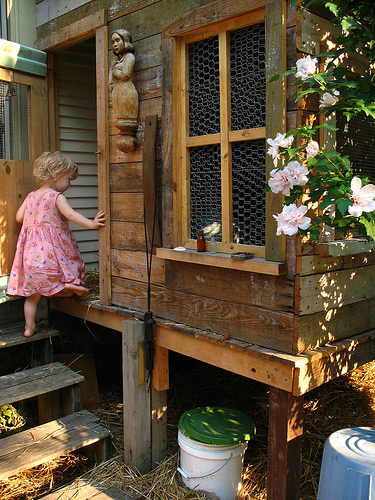

In [7]:
from IPython.display import Image
Image("flickr8k/Images/1000268201_693b08cb0e.jpg")

In [8]:
# Lưu caption dưới d⁄ng key value:
#id_image : ['caption 1', 'caption 2', 'caption 3',' caption 4', 'caption 5']
def load_descriptions(doc):
  mapping = dict()
  # process lines
  for line in doc.split('\n'):
    # split line by white space
    tokens = line.split()
    if len(line) < 2:
      continue
    # take the first token as the image id, the rest as the description
    image_id, image_desc = tokens[0], tokens[1:]
    # extract filename from image id
    image_id = image_id.split('.')[0]
    # convert description tokens back to string
    image_desc = ' '.join(image_desc)
    # create the list if needed
    if image_id not in mapping:
      mapping[image_id] = list()
    # store description
    mapping[image_id].append(image_desc)
  return mapping

descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))
descriptions['1000268201_693b08cb0e']

Loaded: 8092 


['child in a pink dress is climbing up a set of stairs in an entry way .',
 'girl going into a wooden building .',
 'little girl climbing into a wooden playhouse .',
 'little girl climbing the stairs to her playhouse .',
 'little girl in a pink dress going into a wooden cabin .']

In [9]:
# Preprocessing text
def clean_descriptions(descriptions):
  # prepare translation table for removing punctuation
  table = str.maketrans('', '', string.punctuation)
  for key, desc_list in descriptions.items():
    for i in range(len(desc_list)):
      desc = desc_list[i]
      # tokenize
      desc = desc.split()
      # convert to lower case
      desc = [word.lower() for word in desc]
      # remove punctuation from each token
      desc = [w.translate(table) for w in desc]
      # remove hanging 's' and 'a'
      desc = [word for word in desc if len(word)>1]
      # remove tokens with numbers in them
      desc = [word for word in desc if word.isalpha()]
      # store as string
      desc_list[i] = ' '.join(desc)
# clean descriptions
clean_descriptions(descriptions)
descriptions['1000268201_693b08cb0e']

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [10]:
# Lưu description xuống file
def save_descriptions(descriptions, filename):
  lines = list()
  for key, desc_list in descriptions.items():
    for desc in desc_list:
      lines.append(key + ' ' + desc)
  data = '\n'.join(lines)
  file = open(filename, 'w')
  file.write(data)
  file.close()
save_descriptions(descriptions, 'descriptions.txt')

In [12]:

# Đọc dữ liệu từ file captions.txt
df = pd.read_csv('flickr8k/captions.txt')

# Lấy danh sách các id_image từ cột 'image'
unique_ids = df['image'].unique()

# Trộn danh sách id_image một cách ngẫu nhiên
np.random.shuffle(unique_ids)

# Xác định số lượng phần tử cho tập huấn luyện và tập kiểm tra
num_train = 6000
num_test = len(unique_ids) - num_train

# Tách danh sách các id_image sau khi đã trộn
train_ids = unique_ids[:num_train]
test_ids = unique_ids[num_train:]

# Đường dẫn đến thư mục chứa các file text
text_dir = 'flickr8k/text/'

# Tạo thư mục nếu chưa tồn tại
os.makedirs(text_dir, exist_ok=True)

# Lưu vào các file train.txt và test.txt
with open('flickr8k/text/trainImages.txt', 'w') as f:
    for id in train_ids:
        f.write(f"{id}\n")

with open('flickr8k/text/testImages.txt', 'w') as f:
    for id in test_ids:
        f.write(f"{id}\n")

print(f"Train IDs: {len(train_ids)}, Test IDs: {len(test_ids)}")

Train IDs: 6000, Test IDs: 2091


In [13]:
# Lấy id ảnh tương ứng với dữ liệu train, test, dev
def load_set(filename):
  doc = load_doc(filename)
  dataset = list()
  # process line by line
  for line in doc.split('\n'):
    # skip empty lines
    if len(line) < 1:
      continue
    # get the image identifier
    identifier = line.split('.')[0]
    dataset.append(identifier)
  return set(dataset)



In [14]:
# Load training dataset (6K)
filename = 'flickr8k/text/trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))

# Folder chứa dữ ảnh
images = 'flickr8k/Images/'
# Lấy các ảnh jpg trong thư mục
img = glob.glob(images + '*.jpg')
# File chứa các ảnh train
train_images_file = 'flickr8k/text/trainImages.txt'
# Read the train image names in a set
train_images = set(open(train_images_file, 'r').read().strip().split('\n'))

# Tạo tập train
train_img = []
for i in img:
  if i[len(images):] in train_images:
    train_img.append(i)

print(train_img)

Dataset: 6000
['flickr8k/Images\\1000268201_693b08cb0e.jpg', 'flickr8k/Images\\1001773457_577c3a7d70.jpg', 'flickr8k/Images\\1002674143_1b742ab4b8.jpg', 'flickr8k/Images\\1003163366_44323f5815.jpg', 'flickr8k/Images\\1007129816_e794419615.jpg', 'flickr8k/Images\\1007320043_627395c3d8.jpg', 'flickr8k/Images\\1009434119_febe49276a.jpg', 'flickr8k/Images\\1015584366_dfcec3c85a.jpg', 'flickr8k/Images\\101654506_8eb26cfb60.jpg', 'flickr8k/Images\\101669240_b2d3e7f17b.jpg', 'flickr8k/Images\\1016887272_03199f49c4.jpg', 'flickr8k/Images\\1019604187_d087bf9a5f.jpg', 'flickr8k/Images\\1020651753_06077ec457.jpg', 'flickr8k/Images\\1022454332_6af2c1449a.jpg', 'flickr8k/Images\\102351840_323e3de834.jpg', 'flickr8k/Images\\102455176_5f8ead62d5.jpg', 'flickr8k/Images\\1026685415_0431cbf574.jpg', 'flickr8k/Images\\1028205764_7e8df9a2ea.jpg', 'flickr8k/Images\\103106960_e8a41d64f8.jpg', 'flickr8k/Images\\103205630_682ca7285b.jpg', 'flickr8k/Images\\1032122270_ea6f0beedb.jpg', 'flickr8k/Images\\1041368

In [15]:
# File chứa các ảnh test
test_images_file = 'flickr8k/text/testImages.txt'
# Read the test image names in a set
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))

# Tạo tập test
test_img = []
for i in img:
  if i[len(images):] in test_images:
    test_img.append(i)


In [16]:
# Thêm 'startseq', 'endseq' cho chuỗi
def load_clean_descriptions(filename, dataset):
  # load document
  doc = load_doc(filename)
  descriptions = dict()
  for line in doc.split('\n'):
    # split line by white space
    tokens = line.split()
    # split id from description
    image_id, image_desc = tokens[0], tokens[1:]
    # skip images not in the set
    if image_id in dataset:
      # create list
      if image_id not in descriptions:
        descriptions[image_id] = list()
      # wrap description in tokens
      desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
      # store
      descriptions[image_id].append(desc)
  return descriptions
# descriptions
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))
print(train_descriptions)

Descriptions: train=6000
{'1000268201_693b08cb0e': ['startseq child in pink dress is climbing up set of stairs in an entry way endseq', 'startseq girl going into wooden building endseq', 'startseq little girl climbing into wooden playhouse endseq', 'startseq little girl climbing the stairs to her playhouse endseq', 'startseq little girl in pink dress going into wooden cabin endseq'], '1001773457_577c3a7d70': ['startseq black dog and spotted dog are fighting endseq', 'startseq black dog and tricolored dog playing with each other on the road endseq', 'startseq black dog and white dog with brown spots are staring at each other in the street endseq', 'startseq dogs of different breeds looking at each other on the road endseq', 'startseq dogs on pavement moving toward each other endseq'], '1002674143_1b742ab4b8': ['startseq little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq', 'startseq little girl is sitting in front of large painted rainbow endseq',

In [17]:
# Load ảnh, resize về kích thước mà Inception v3 yêu cầu
def preprocess(image_path):
  # Convert all the images to size 299x299 as expected by the inception v3 model
  img = image.load_img(image_path, target_size=(299, 299))
  # Convert PIL image to numpy array of 3-dimensions
  x = image.img_to_array(img)
  # Add one more dimension
  x = np.expand_dims(x, axis=0)
  # preprocess the images using preprocess_input() from inception module
  x = preprocess_input(x)
  return x
# Load the inception v3 model
model = InceptionV3(weights='imagenet')
# Tạo model mới, bỏ layer cuối từ inception v3
model_new = Model(model.input, model.layers[-2].output)

96112376/96112376 ━━━━━━━━━━━━━━━━━━━━ 14s 0us/step


In [18]:
# Image embedding thành vector (2048, )
def encode(image):
  image = preprocess(image) # preprocess the image
  fea_vec = model_new.predict(image) # Get the encoding vector for the image
  fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
  return fea_vec

In [19]:
# Gọi hàm encode với các ảnh trong training set
start = time()
encoding_train = {}
for img in train_img:
  encoding_train[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/

In [20]:
# Đường dẫn đến thư mục chứa các file encoder
encode_dir = 'flickr8k/Pickle/'

# Tạo thư mục nếu chưa tồn tại
os.makedirs(encode_dir, exist_ok=True)

# Lưu image embedding lại
with open("flickr8k/Pickle/encoded_train_images.pkl", "wb") as encoded_pickle:
  dump(encoding_train, encoded_pickle)
train_features = load(open("flickr8k/Pickle/encoded_train_images.pkl", "rb"))
print('Photos: train=%d' % len(train_features))

Photos: train=6000


In [21]:
# Encode test image
start = time()
encoding_test = {}
for img in test_img:
  encoding_test[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106m

In [22]:
# Save the bottleneck test features to disk
with open("flickr8k/Pickle/encoded_test_images.pkl", "wb") as encoded_pickle:
  dump(encoding_test, encoded_pickle)

In [23]:
# T⁄o list c¡c training caption
all_train_captions = []
for key, val in train_descriptions.items():
  for cap in val:
    all_train_captions.append(cap)
len(all_train_captions)
# Chỉ lấy các từ xuất hiện 10 lần
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
  nsents += 1
  for w in sent.split(' '):
    word_counts[w] = word_counts.get(w, 0) + 1
vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))

ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
  wordtoix[w] = ix
  ixtoword[ix] = w
  ix += 1
vocab_size = len(ixtoword) + 1 # Thêm 1 cho từ dùng để padding
vocab_size

preprocessed words 7634 -> 1642


1643

In [24]:
# convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
  all_desc = list()
  for key in descriptions.keys():
    [all_desc.append(d) for d in descriptions[key]]
  return all_desc
# calculate the length of the description with the most words
def max_length(descriptions):
  lines = to_lines(descriptions)
  return max(len(d.split()) for d in lines)

# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description max Length: %d' % max_length)

Description max Length: 33


Mô hình GloVe (Global Vectors for Word Representation) là một phương pháp phổ biến để chuyển đổi các từ ngữ thành các vector số học, giúp các mô hình học máy và xử lý ngôn ngữ tự nhiên (NLP) hiểu và xử lý văn bản hiệu quả hơn. Mô hình GloVe đã được đào tạo trên một tập dữ liệu lớn và cung cấp các vector từ đại diện cho từ ngữ.

In [26]:
# Load Glove model
glove_dir = ''
embeddings_index = {} # empty dictionary
f = open(os.path.join(glove_dir, 'glove6b200d/glove.6B.200d.txt'), encoding="utf-8")
for line in f:
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

In [27]:
print('Found %s word vectors.' % len(embeddings_index))
embeddings_index['the']
embedding_dim = 200

Found 400000 word vectors.


In [28]:
# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in wordtoix.items():
  #if i < max_words:
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    # Words not found in the embedding index will be all zeros
    embedding_matrix[i] = embedding_vector
embedding_matrix.shape

(1643, 200)

In [29]:
# Tạo model
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 33)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 2048)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 33, 200)   │    328,600 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 2048)      │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 33, 200)   │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 33)        │          0 │ input_layer_2[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    524,544 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 256)       │    467,968 │ dropout_1[0][0],  │
│                     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256)       │          0 │ dense[0][0],      │
│                     │                   │            │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │     65,792 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1643)      │    422,251 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,809,155 (6.90 MB)

 Trainable params: 1,809,155 (6.90 MB)

 Non-trainable params: 0 (0.00 B)

In [62]:

def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch, vocab_size):
    X1, X2, y = [], [], []
    n = 0
    
    while True:
        for key, desc_list in descriptions.items():
            n += 1
            # Retrieve the photo feature
            photo = photos[key + '.jpg']
            
            for desc in desc_list:
                # Encode the sequence
                seq = [wordtoix.get(word, 0) for word in desc.split(' ')]  # Use .get to handle unknown words
                
                # Split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # Split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    
                    # Pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    
                    # Encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # Store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            
            # Yield the batch data
            if n == num_photos_per_batch:
                yield (np.array(X1), np.array(X2)), np.array(y)
                X1, X2, y = [], [], []
                n = 0

In [65]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True )

# Set GloVe weights and freeze the layer
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam')
# Set the learning rate for the optimizer
model.optimizer.lr = 0.1
epochs = 30
number_pics_per_batch = 6
steps = len(train_descriptions) // number_pics_per_batch  # Number of steps per epoch

In [67]:
for epoch in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_batch, vocab_size)
    history=model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1,callbacks=[early_stopping])

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 246s 244ms/step - loss: 4.0732
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 238s 238ms/step - loss: 3.5133
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 234s 234ms/step - loss: 3.2982
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 196s 196ms/step - loss: 3.1710
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 197s 197ms/step - loss: 3.0797
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 208s 208ms/step - loss: 3.0041
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 211s 211ms/step - loss: 2.9413
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 217s 217ms/step - loss: 2.8922
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 200s 200ms/step - loss: 2.8486
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 197s 197ms/step - loss: 2.8104
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 193s 193ms/step - loss: 2.7813
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 193s 193ms/step - loss: 2.7492
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 196s 196ms/step - loss: 2.7237
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 193s 193ms/step - loss: 2.6985
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 193s 193ms/step - loss: 2.6771
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 192s 192ms/step - loss: 2.6571
1000/100

In [68]:
# Lưu trọng số mô hình
model.save_weights('model_weights/model_30.h5')

ValueError: The filename must end in `.weights.h5`. Received: filepath=model_weights/model_30.h5

In [ ]:
# Vẽ biểu đồ loss và accuracy
plt.figure(figsize=(12, 5))

# Biểu đồ loss
plt.subplot(1, 2, 1)
plt.plot(history['loss'])
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.tight_layout()
plt.show()

In [ ]:
images = 'flickr8k/Images/'
with open("flickr8k/Pickle/encoded_test_images.pkl", "rb") as encoded_pickle:
  encoding_test = load(encoded_pickle)

Với mỗi ảnh mới khi test, ta sẽ bắt đầu chuỗi với 'startseq rồi sau đó cho vào model để dự đoán từ tiếp theo. Ta thêm từ vừa được dự đoán vào chuỗi và tiếp tục cho đến khi gặp 'endseq' là kết thúc hoặc cho đến khi chuỗi dài 34 kí tự

In [ ]:
def greedySearch(photo):
  in_text = 'startseq'
  for i in range(max_length):
    sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
    sequence = pad_sequences([sequence], maxlen=max_length)
    yhat = model.predict([photo,sequence], verbose=0)
    yhat = np.argmax(yhat)
    word = ixtoword[yhat]
    in_text += ' ' + word
    if word == 'endseq':
      break
  final = in_text.split()
  final = final[1:-1]
  final = ' '.join(final)
  return final

In [ ]:
z=5
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print(greedySearch(image))